https://www.kaggle.com/code/madisonchung/day-3a-agent-sessions-yujinc/edit

In [1]:
from dotenv import load_dotenv
import os
from pathlib import Path

env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

# reference: https://stackoverflow.com/questions/16924471/difference-between-os-getenv-and-os-environ-get
try:
    api_key = os.environ["GOOGLE_API_KEY"]
    os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' in .env file. Details: {e}")

✅ Gemini API key setup complete.


In [2]:
from typing import Any, Dict

from google.adk.agents import Agent, LlmAgent
from google.adk.apps.app import App, EventsCompactionConfig
from google.adk.models.google_llm import Gemini
from google.adk.sessions import DatabaseSessionService
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.adk.tools.tool_context import ToolContext
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [3]:
# Define helper functions that will be reused throughout the notebook
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    # Get app name from the Runner
    app_name = runner_instance.app_name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        # Process each query in the list sequentially
        for query in user_queries:
            print(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Stream the agent's response asynchronously
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    # Filter out empty or "None" responses before printing
                    if (
                        event.content.parts[0].text != "None"
                        and event.content.parts[0].text
                    ):
                        print(f"{MODEL_NAME} > ", event.content.parts[0].text)
    else:
        print("No queries!")


print("✅ Helper functions defined.")

✅ Helper functions defined.


In [4]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

## Sessions - for short term memory management.

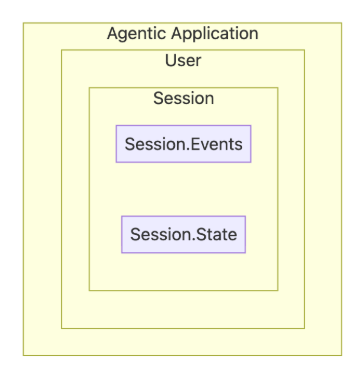

In [5]:
APP_NAME = "default"  # Application
USER_ID = "default"  # User
SESSION = "default"  # Session

MODEL_NAME = "gemini-2.5-flash-lite"


# Step 1: Create the LLM Agent
root_agent = Agent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="text_chat_bot",
    description="A text chatbot",  # Description of the agent's purpose
)

# Step 2: Set up Session Management
# InMemorySessionService stores conversations in RAM (temporary)
session_service = InMemorySessionService()

# Step 3: Create the Runner
runner = Runner(agent=root_agent, app_name=APP_NAME, session_service=session_service)

print("✅ Stateful agent initialized!")
print(f"   - Application: {APP_NAME}")
print(f"   - User: {USER_ID}")
print(f"   - Using: {session_service.__class__.__name__}")

✅ Stateful agent initialized!
   - Application: default
   - User: default
   - Using: InMemorySessionService


In [6]:
# Run a conversation with two queries in the same session
# Notice: Both queries are part of the SAME session, so context is maintained
await run_session(
    runner,
    [
        "Hi, I am Sam! What is the capital of United States?",
        "Hello! What is my name?",  # This time, the agent should remember!
    ],
    "stateful-agentic-session",
)


 ### Session: stateful-agentic-session

User > Hi, I am Sam! What is the capital of United States?
gemini-2.5-flash-lite >  Hi Sam! The capital of the United States is Washington, D.C.

User > Hello! What is my name?
gemini-2.5-flash-lite >  You told me your name is Sam!


## DatabaseSessionService

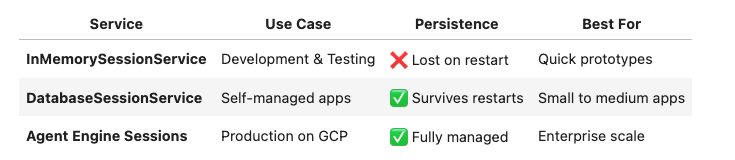

In [7]:
# Step 1: Create the same agent (notice we use LlmAgent this time)
chatbot_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="text_chat_bot",
    description="A text chatbot with persistent memory",
)

# Step 2: Switch to DatabaseSessionService
# SQLite database will be created automatically
db_url = "sqlite:///my_agent_data.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)

# Step 3: Create a new runner with persistent storage
runner = Runner(agent=chatbot_agent, app_name=APP_NAME, session_service=session_service)

print("✅ Upgraded to persistent sessions!")
print(f"   - Database: my_agent_data.db")
print(f"   - Sessions will survive restarts!")

✅ Upgraded to persistent sessions!
   - Database: my_agent_data.db
   - Sessions will survive restarts!


In [8]:
await run_session(
    runner,
    ["Hi, I am Sam! What is the capital of the United States?", "Hello! What is my name?"],
    "test-db-session-01",
)


 ### Session: test-db-session-01

User > Hi, I am Sam! What is the capital of the United States?
gemini-2.5-flash-lite >  Hi Sam! The capital of the United States is Washington, D.C.

User > Hello! What is my name?
gemini-2.5-flash-lite >  Your name is Sam!


In [9]:
await run_session(
    runner,
    ["What is the capital of India?", "Hello! What is my name?"],
    "test-db-session-01",
)


 ### Session: test-db-session-01

User > What is the capital of India?
gemini-2.5-flash-lite >  The capital of India is New Delhi.

User > Hello! What is my name?
gemini-2.5-flash-lite >  Your name is Sam!


In [10]:
await run_session(
    runner, ["Hello! What is my name?"], "test-db-session-02"
)  # Note, we are using new session name


 ### Session: test-db-session-02

User > Hello! What is my name?
gemini-2.5-flash-lite >  I do not have access to your personal information, including your name. Therefore, I cannot tell you what your name is.


In [11]:
import sqlite3

def check_data_in_db():
    with sqlite3.connect("my_agent_data.db") as connection:
        cursor = connection.cursor()
        result = cursor.execute(
            "select app_name, session_id, author, content from events"
        )
        print([_[0] for _ in result.description])
        for each in result.fetchall():
            print(each)


check_data_in_db()

['app_name', 'session_id', 'author', 'content']
('default', 'test-db-session-01', 'user', '{"parts": [{"text": "Hi, I am Sam! What is the capital of the United States?"}], "role": "user"}')
('default', 'test-db-session-01', 'text_chat_bot', '{"parts": [{"text": "Hi Sam! The capital of the United States is Washington, D.C."}], "role": "model"}')
('default', 'test-db-session-01', 'user', '{"parts": [{"text": "Hello! What is my name?"}], "role": "user"}')
('default', 'test-db-session-01', 'text_chat_bot', '{"parts": [{"text": "Your name is Sam!"}], "role": "model"}')
('default', 'test-db-session-01', 'user', '{"parts": [{"text": "What is the capital of India?"}], "role": "user"}')
('default', 'test-db-session-01', 'text_chat_bot', '{"parts": [{"text": "The capital of India is New Delhi."}], "role": "model"}')
('default', 'test-db-session-01', 'user', '{"parts": [{"text": "Hello! What is my name?"}], "role": "user"}')
('default', 'test-db-session-01', 'text_chat_bot', '{"parts": [{"text": 

## EventscompactionConfig

In [12]:
# Re-define our app with Events Compaction enabled
research_app_compacting = App(
    name="research_app_compacting",
    root_agent=chatbot_agent,
    # This is the new part!
    events_compaction_config=EventsCompactionConfig(
        compaction_interval=3,  # Trigger compaction every 3 invocations
        overlap_size=1,  # Keep 1 previous turn for context
    ),
)

db_url = "sqlite:///my_agent_data.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)

# Create a new runner for our upgraded app
research_runner_compacting = Runner(
    app=research_app_compacting, session_service=session_service
)


print("✅ Research App upgraded with Events Compaction!")

✅ Research App upgraded with Events Compaction!


/var/folders/f0/hn8pjjkj23vby6rwl0wv5v_m0000gn/T/ipykernel_51662/3773147741.py:6: UserWarning: [EXPERIMENTAL] EventsCompactionConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  events_compaction_config=EventsCompactionConfig(


In [13]:
# Turn 1
await run_session(
    research_runner_compacting,
    "What is the latest news about AI in healthcare?",
    "compaction_demo",
)

# Turn 2
await run_session(
    research_runner_compacting,
    "Are there any new developments in drug discovery?",
    "compaction_demo",
)

# Turn 3 - Compaction should trigger after this turn!
await run_session(
    research_runner_compacting,
    "Tell me more about the second development you found.",
    "compaction_demo",
)

# Turn 4
await run_session(
    research_runner_compacting,
    "Who are the main companies involved in that?",
    "compaction_demo",
)


 ### Session: compaction_demo

User > What is the latest news about AI in healthcare?
gemini-2.5-flash-lite >  Here's a summary of some of the latest developments and trends in AI in healthcare, as of my last update:

**Key Areas of Advancement and Focus:**

*   **Drug Discovery and Development:**
    *   **Accelerated Target Identification:** AI is becoming increasingly adept at sifting through vast biological datasets to identify potential drug targets much faster than traditional methods. This includes analyzing genomic, proteomic, and clinical data.
    *   **Molecule Design and Optimization:** AI algorithms are being used to design novel drug molecules with desired properties and to optimize existing ones for efficacy and safety. Companies are reporting success in designing molecules for specific diseases.
    *   **Clinical Trial Optimization:** AI is being employed to improve the design of clinical trials, identify suitable patient populations, predict trial outcomes, and even 

In [14]:
# Get the final session state
final_session = await session_service.get_session(
    app_name=research_runner_compacting.app_name,
    user_id=USER_ID,
    session_id="compaction_demo",
)

print("--- Searching for Compaction Summary Event ---")
found_summary = False
for event in final_session.events:
    # Compaction events have a 'compaction' attribute
    if event.actions and event.actions.compaction:
        print("\n✅ SUCCESS! Found the Compaction Event:")
        print(f"  Author: {event.author}")
        print(f"\n Compacted information: {event}")
        found_summary = True
        break

if not found_summary:
    print(
        "\n❌ No compaction event found. Try increasing the number of turns in the demo."
    )

--- Searching for Compaction Summary Event ---

✅ SUCCESS! Found the Compaction Event:
  Author: user

 Compacted information: model_version=None content=None grounding_metadata=None partial=None turn_complete=None finish_reason=None error_code=None error_message=None interrupted=None custom_metadata=None usage_metadata=None live_session_resumption_update=None input_transcription=None output_transcription=None avg_logprobs=None logprobs_result=None cache_metadata=None citation_metadata=None invocation_id='ef69a66a-d0db-41e6-8086-203df9bcf4da' author='user' actions=EventActions(skip_summarization=None, state_delta={}, artifact_delta={}, transfer_to_agent=None, escalate=None, requested_auth_configs={}, requested_tool_confirmations={}, compaction={'start_timestamp': 1764091101.077699, 'end_timestamp': 1764091114.08481, 'compacted_content': {'parts': [{'function_call': None, 'code_execution_result': None, 'executable_code': None, 'file_data': None, 'function_response': None, 'inline_data':